# Load Profile Forecasting

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy import stats

In [284]:
data_test = pd.read_csv("../src/data/8.4_test.csv", parse_dates = ["date"]).fillna(0).set_index("date")
data_train = pd.read_csv("../src/data/8.4_train.csv", parse_dates = ["date"]).fillna(0).set_index("date")
data = pd.read_csv("../src/data/8.4_cleaned.csv", parse_dates = ["date"]).fillna(0).set_index("date")
#data = data.iloc[::10]
data_test.head(2)

,airTemp,GHI,PAI,L,PV
date,,,,,
2021-03-28 00:00:00,-1.766667,0.0,0.0,167.6250,0.0
2021-03-28 00:10:00,-2.000000,0.0,0.0,175.6875,0.0


In [285]:
#data_test = data_test.resample(rule = "2H").mean()
#data_train = data_train.resample(rule = "2H").mean()


## Step 1 - Statistical Properties

After the cleaning the timeseries is
1. Discrete
2. Evenly sampled

We will see if the timesseries is: 
1. Multivariate or univariate
2. Periodic or aperiodic
3. Stationary or nonstationary


### Multivariate vs. univariate


[]

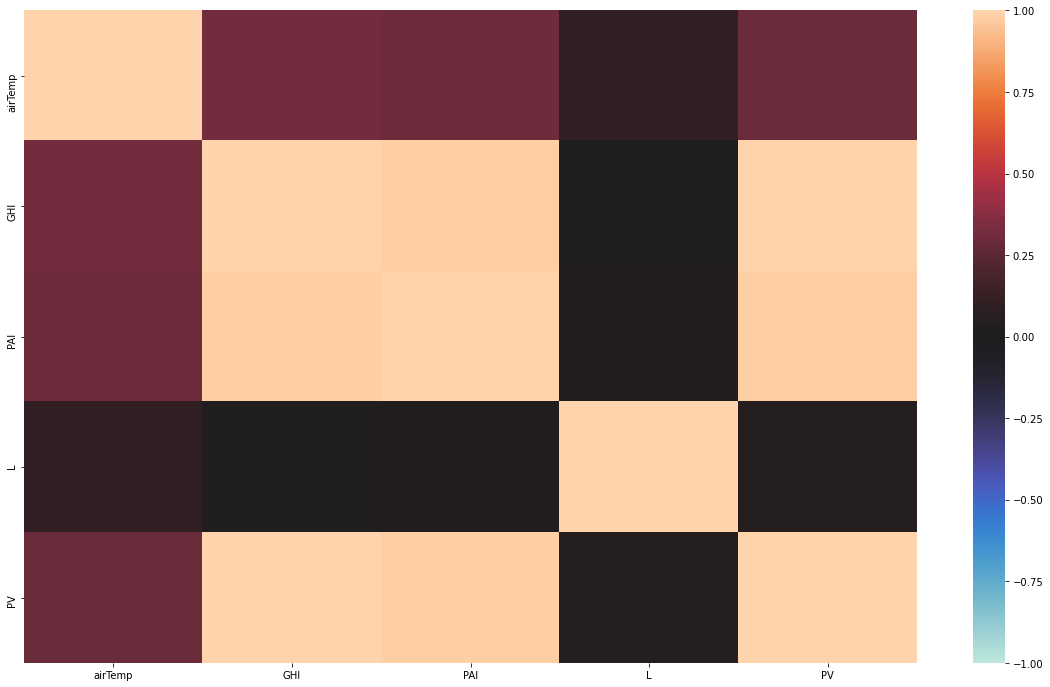

In [146]:
corr = data_test.groupby(data_test.index.day).mean().corr()

plt.figure(figsize = (20, 12))
sn.heatmap(corr, vmin = -1, vmax = 1, center = 0)
plt.plot()

In [147]:
corr

,airTemp,GHI,PAI,L,PV
airTemp,1.000000,0.313881,0.299163,0.105204,0.289110
GHI,0.313881,1.000000,0.982884,0.014526,0.999041
PAI,0.299163,0.982884,1.000000,0.029342,0.982910
L,0.105204,0.014526,0.029342,1.000000,0.040336
PV,0.289110,0.999041,0.982910,0.040336,1.000000


In [148]:
def extract_timeperiod(data, start, end):
    return data[(data.date >= start) & (data.date <=end)]

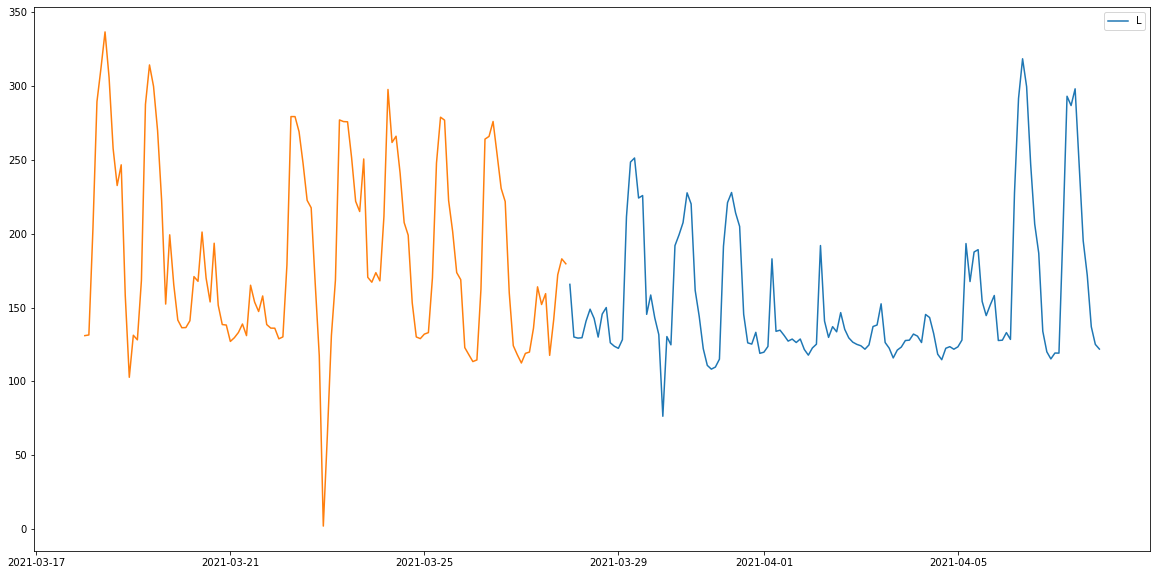

In [149]:
def plot_series_in_df(df, series):
    t = df.index

    for serie in series:
        plt.plot(t, df[serie].values)
        
    plt.legend(series)

plt.figure(figsize = (20, 10))
plot_series_in_df(data_test, ["L"])
plot_series_in_df(data_train, ["L"])


In [150]:
import sys
sys.path.insert(1, "../src/components")
from loads import Load

ValueError: x and y must have same first dimension, but have shapes (60,) and (32,)

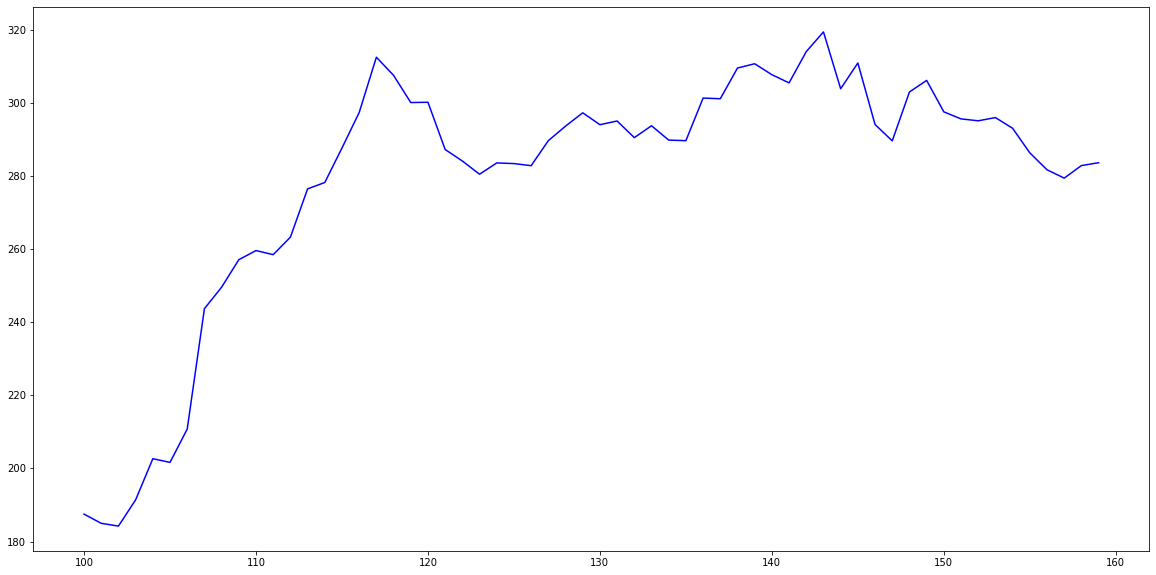

In [151]:
N = 60
L = Load(N, "../src/data/8.4_test.csv", "L")

plt.figure(figsize = (20,10))
for step in range(100, 1000, 10):
    
    obs = data_test["L"].iloc[step:step+N].values
    plt.plot(range(step, step+N), L.scaled_mean_pred(obs[0], step %(144-N)), color = "blue")
    plt.plot(range(step, step+N), obs, color = "red")

In [177]:

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(last_ob, value):
    return value + last_ob

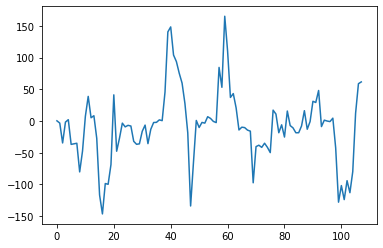

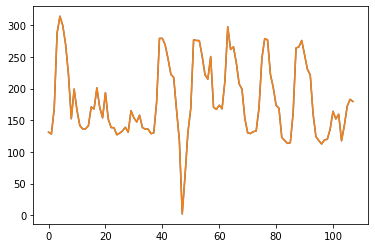

In [214]:
data_train_diff = difference(data_train.L, 12)

plt.figure()
plt.plot(data_train_diff)
plt.figure()
plt.plot([inverse_difference(data_train.L[i], data_train_diff[i]) for i in range(len(data_train_diff))])
plt.plot(data_train.L.values[12:])

In [229]:
data_train['z_L'] = (data_train['L'] - data_train.L.rolling(window=12).mean()) / data_train.L.rolling(window=12).std()
data_train['zp_L'] = data_train['z_L'] - data_train['z_L'].shift(12)

df = data_train.copy()


In [231]:
from statsmodels.tsa.stattools import adfuller, kpss

print(" > Is the data stationary ?")
dftest = adfuller(df.L, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df.z_L.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df.zp_L.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


 > Is the data stationary ?
Test statistic = -2.542
P-value = 0.106
Critical values :
	1%: -3.4912451337340342 - The data is not stationary with 99% confidence
	5%: -2.8881954545454547 - The data is not stationary with 95% confidence
	10%: -2.5809876033057852 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -6.968
P-value = 0.000
Critical values :
	1%: -3.4942202045135513 - The data is  stationary with 99% confidence
	5%: -2.889485291005291 - The data is  stationary with 95% confidence
	10%: -2.5816762131519275 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -2.945
P-value = 0.040
Critical values :
	1%: -3.510711795769895 - The data is not stationary with 99% confidence
	5%: -2.8966159448223734 - The data is  stationary with 95% confidence
	10%: -2.5854823866213152 - The data is  stationary with 90% confidence


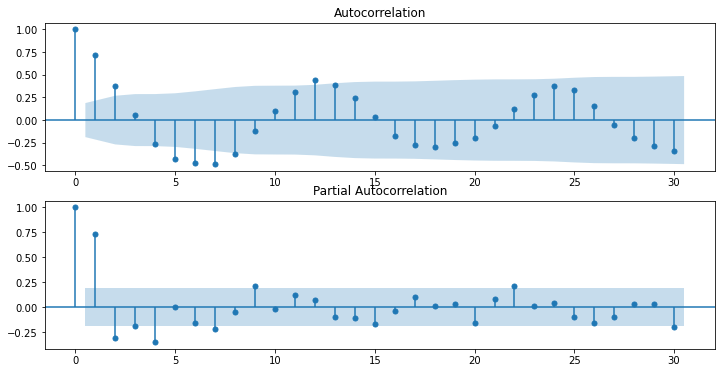

In [234]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.z_L.dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(df.z_L.dropna(), ax=ax[1], lags=30)

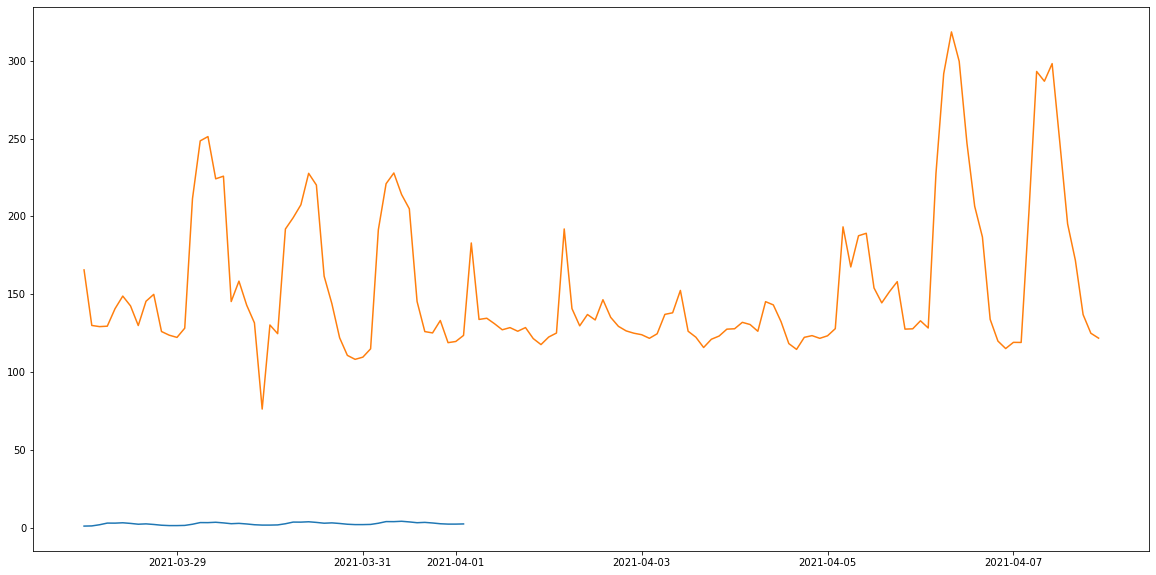

In [247]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(df.z_L,trend = "n", order = (0,1, 0), seasonal_order=(1,1,1,12))
res = model.fit()
plt.figure(figsize = (20,10))
plt.plot(res.forecast(50))
plt.plot(data_test.L)

(2880, 5) (432, 5) (2448, 5)


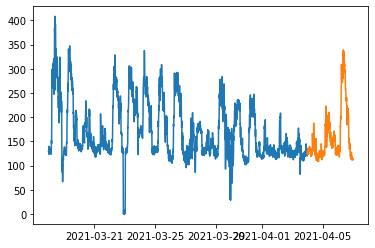

In [273]:
from pmdarima.arima import ADFTest, auto_arima
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data_train.L)

train = data.iloc[:int(0.85*data.shape[0])]
test = data.iloc[-int(0.15*data.shape[0]):]
print(data.shape, test.shape,train.shape)
plt.plot(train.L)
plt.plot(test.L)

In [276]:
arima_model = auto_arima(train.L, p= 0, d = 1, start_q=0, max_p = 5, max_d = 5,
                        max_q = 5, start_P = 0, D = 1, start_Q = 0, max_P = 2, max_D = 2,
                        max_Q = 1, m = 12, seasonal =True, error_action= "warn", trace = True,
                        supress_warnings = True, stepwise = True, random_state = 20, n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=21277.943, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=21299.636, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=20578.816, Time=0.49 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=21281.912, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=20306.441, Time=0.99 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.14 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.44 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=20323.349, Time=0.94 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=20304.651, Time=1.45 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=20573.436, Time=0.65 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=8.70 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.83 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=20304.599, Time=1.72 sec
 ARIMA(3,1,0)(1,1,0)[12]           

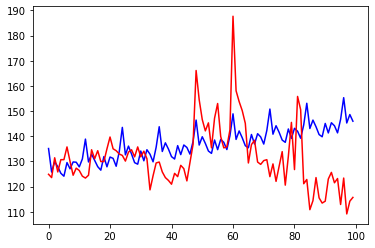

In [278]:
n = 100
plt.plot(arima_model.predict(n_periods = n), color = "blue")
plt.plot(test.L.iloc[0:n].values, color = "red")

## Fourier Transform

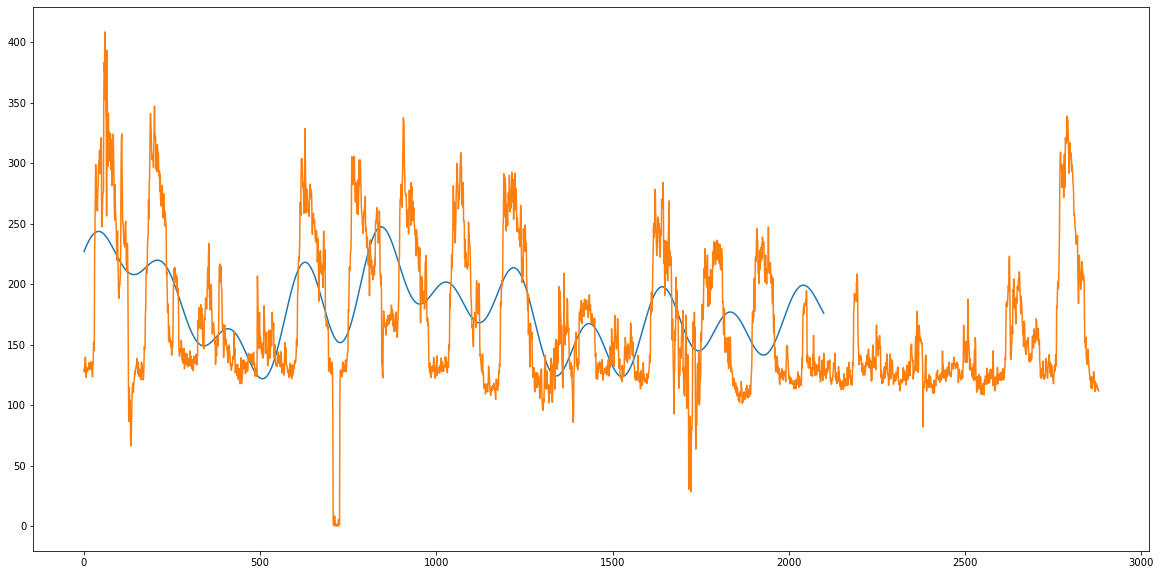

In [317]:

def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 10                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = np.fft.fft(x_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
    
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + (p[0]) * t


pred = fourierExtrapolation(data.L.iloc[:2000].values, 100)
plt.figure(figsize = (20,10))
plt.plot(pred)
plt.plot(data.L.values)
#plt.plot(range(data_train.shape[0],data_train.shape[0]+ data_test.shape[0]), data_test.L.values)

### Extract the errors for each timestep.

The chosen prediction method is tested for every day, and all errors for all timesteps are collected. To make the errors more readable, they are divided by the the groundtruth to get the percentage error.

In [26]:
def calculate_errors_for_day(column, num_steps, groundtruth):
    
    l = Load(num_steps, "./data/loads_train.csv", column, groundtruth=groundtruth)
    errors = []
    for step in range(groundtruth.shape[0]-num_steps):
        gt = l.get_groundtruth(step)
        pred = l.get_constant_pred(gt[0], step)
        errors.append(((pred-gt)/gt)[1:])
    return np.asarray(errors)
    
def calculate_errors(data, column, num_steps):
    
    grouped = data.groupby(data.date.dt.day)
    day_errors = []
    for day, df in grouped:
        day_error = calculate_errors_for_day(column, num_steps, df[column])
        day_errors.append(day_error)
    return np.asarray(day_errors)
    
        
errors = calculate_errors(data, "L", 13)

/Users/theo/anaconda3/envs/ml36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [27]:
plt.figure(figsize = (20, 10))
for step in range(errors.shape[1]):
    plt.scatter(range(step, step + errors.shape[2]), errors[3][step])

IndexError: tuple index out of range

<Figure size 1440x720 with 0 Axes>

Then the errors for each timestep in the prediction horizion is extracted. Note that we do not make a difference on time of day.

In [23]:
import time
dist = []
error_df = pd.DataFrame()
for k in range(errors.shape[2]):
    num_bins = 200
    
    err = errors[:,:,k].flatten()
    error_df[k+1] = errors[:,:,k].flatten()
    std = np.std(err)
    mean = np.mean(err)
    sigma = np.var(err)
    dist.append([mean, std])
    
    """
    x = np.linspace(mean - 3*sigma, mean + 3*sigma, num_bins)
    print("Prediction step:", k)
    print("Standard deviation:", std)
    print("Mean:", mean)
    

    plt.hist(err, bins = num_bins)
    plt.plot(x, stats.norm.pdf(x, mean, sigma))
    plt.show()
    time.sleep(0.2)
    """
error_df.describe()

,1,2,3,4,5,6,7,8,9,10,11,12
count,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000
mean,0.018838,0.038114,0.068034,0.073285,0.074842,0.074416,0.077667,0.079649,0.081397,0.081524,0.083228,0.084748
std,1.035812,1.535929,2.301928,2.445338,2.453408,2.291778,2.281391,2.273286,2.238329,2.094499,2.032750,1.960649
min,-0.990786,-0.990680,-0.990779,-0.990433,-0.990296,-0.990886,-0.990934,-0.990409,-0.990238,-0.990916,-0.991115,-0.990796
25%,-0.042061,-0.054507,-0.063027,-0.069680,-0.070902,-0.076512,-0.082323,-0.080122,-0.086014,-0.089935,-0.097479,-0.099296
50%,0.000874,0.001009,0.002296,0.003119,0.006408,0.006802,0.010414,0.014139,0.013152,0.015000,0.016043,0.019279
75%,0.044386,0.055914,0.067030,0.077546,0.082174,0.090797,0.100656,0.113055,0.119859,0.133218,0.140216,0.150958
max,65.757143,76.758916,99.481568,116.041226,122.754463,108.723694,105.812888,109.300500,110.540589,99.351323,98.448827,96.691339


Now we plot the box plot with the errors in percentage on the y axis, and the timestep on xaxis. We can observe that the mean is centered around zero, and there is a wider spread the further into the predictions we get.

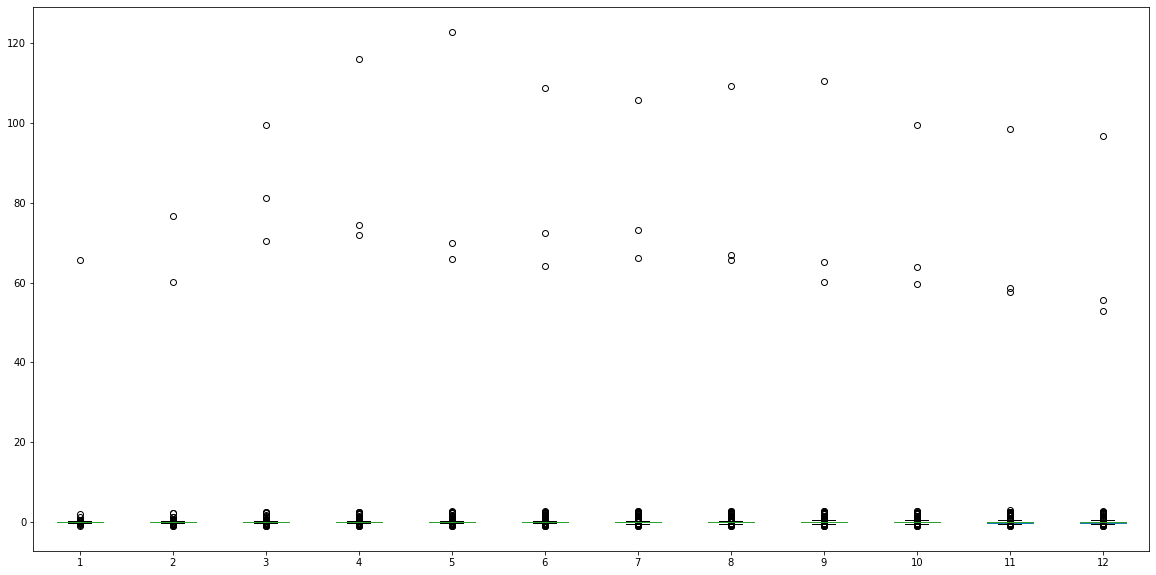

In [24]:
plt.show(error_df.plot.box(figsize = (20,10)))

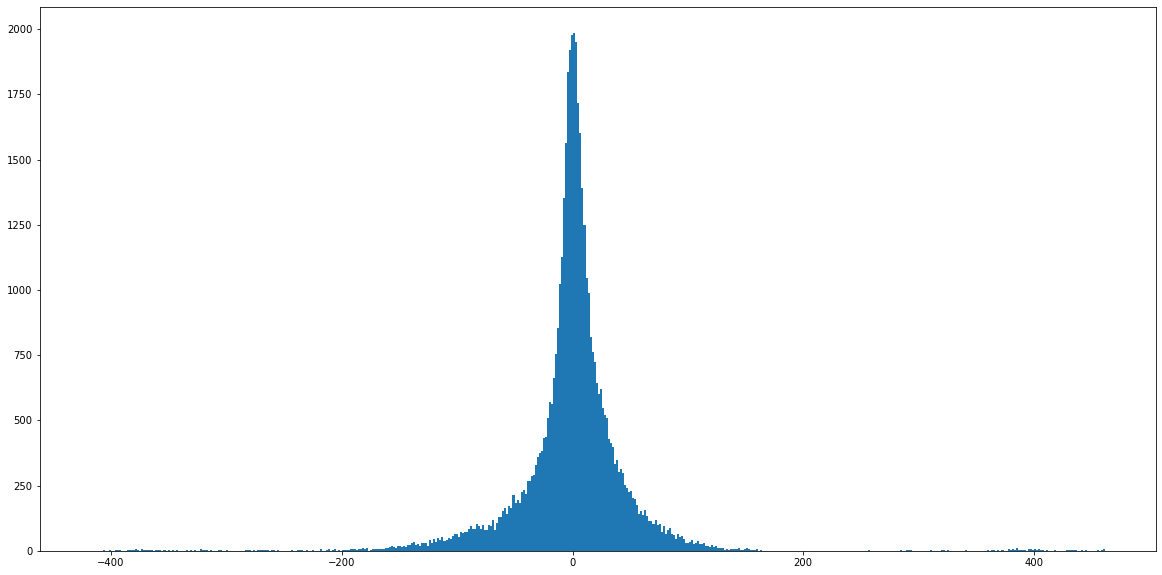

In [19]:
def plot_error_hist(errors):
    plt.figure(figsize = (20, 10))
    plt.hist(errors.flatten(), bins = 500)
    

plot_error_hist(errors)

#### Statistical tests
We wish to test if the data is normally distributed, and to do this we use the Lilliefors test [(Wikipedia)](https://en.wikipedia.org/wiki/Lilliefors_test). The advantage of this test is that it does not specify which normal distribution, meaning we dont have to make assumptions around mean and variance. If 

In [22]:
from statsmodels.stats.diagnostic import lilliefors

print("Lilliefors Test")
for i in range(1,13):
    print("P-Value at step {}: {}".format(i, lilliefors(error_df[i], dist = "norm")[1]))

Lilliefors Test
P-Value at step 1: 0.0009999999999998899
P-Value at step 2: 0.0009999999999998899
P-Value at step 3: 0.0009999999999998899
P-Value at step 4: 0.0009999999999998899
P-Value at step 5: 0.0009999999999998899
P-Value at step 6: 0.0009999999999998899
P-Value at step 7: 0.0009999999999998899
P-Value at step 8: 0.0009999999999998899
P-Value at step 9: 0.0009999999999998899
P-Value at step 10: 0.0009999999999998899
P-Value at step 11: 0.0009999999999998899
P-Value at step 12: 0.0009999999999998899


In [23]:
from scipy.stats import kstest

print("Kolmogorov–Smirnov Test")
for i in range(1,13):
    print("P-Value at step {}: {}".format(i, kstest(error_df[i], "norm")[1]))

Kolmogorov–Smirnov Test
P-Value at step 1: 0.0
P-Value at step 2: 0.0
P-Value at step 3: 0.0
P-Value at step 4: 0.0
P-Value at step 5: 0.0
P-Value at step 6: 0.0
P-Value at step 7: 0.0
P-Value at step 8: 0.0
P-Value at step 9: 0.0
P-Value at step 10: 0.0
P-Value at step 11: 0.0
P-Value at step 12: 0.0


The statistical tests fails, so we cannot assume the errors are normally distributed. Therefore we cannot fit a normal distribution. This makes sense as the error depends on time of day.

### Perodicness

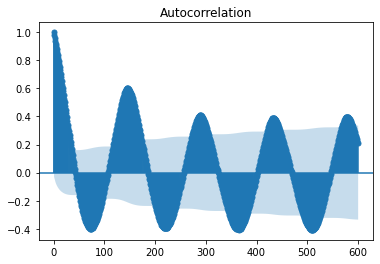

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_acf(data["L"], lags = 600)
plt.show()